What we need is a small parcel to work on, with a nice contourplot with critical points and minima found after initiating local method and then a 3d plot. 

In [1]:
using Globtim
include("../src/lib_func.jl")

# Constants and Parameters
d = 4 # Initial Degree 
const n, a, b = 2, 10, 1 
const scale_factor = a / b       # Scaling factor appears in `main_computation`, maybe it should be a parameter.
const delta, alpha = .9 , 8 / 10  # Sampling parameters
const tol_l2 = 3e-2             # Define the tolerance for the L2-norm

f = CrossInTray # Objective function

CrossInTray (generic function with 1 method)

We need to also return the number of samples used to generate the sample set. It is annoying that the error goes up while the degree has increased.

In [2]:
while true # Potential infinite loop
    global poly_approx = MainGenerate(f, 2, d, delta, alpha, scale_factor, 0.5) # computes the approximant in Chebyshev basis
    if poly_approx.nrm < tol_l2
        println("attained the desired L2-norm: ", poly_approx.nrm)
        break
    else
        println("current L2-norm: ", poly_approx.nrm)
        println("Number of samples: ", poly_approx.N)
        global d += 1
    end
end

current L2-norm: 0.04226530787177835
Number of samples: 17
current L2-norm: 0.21877316208032133
Number of samples: 22
current L2-norm: 0.1377083991915426
Number of samples: 28
current L2-norm: 0.037779858002456146
Number of samples: 35
current L2-norm: 0.07998046709861971
Number of samples: 42
current L2-norm: 0.06967953221185019
Number of samples: 50
current L2-norm: 0.058192027377838344
Number of samples: 58
attained the desired L2-norm: 0.01906774261095705


We now expand the approximant computed in the tensorized Chebyshev basis into standard monomial basis.

In [3]:
using DynamicPolynomials, HomotopyContinuation, ProgressLogging, DataFrames
@polyvar(x[1:n]) # Define polynomial ring 
ap = main_nd(n, d, poly_approx.coeffs) 
# Expand the polynomial approximant to the standard monomial basis in the Lexicographic order w.r.t x. 
PolynomialApproximant = sum(Float64.(ap) .* MonomialVector(x, 0:d)) # Convert coefficients to Float64 for homotopy continuation
grad = differentiate.(PolynomialApproximant, x)
sys = System(grad);

Solve the system of partial derivatives using HomotopyContinuation. Note: restricted to Floats64 coefficients. 

In [4]:
Real_sol_lstsq = HomotopyContinuation.solve(sys)
real_pts = HomotopyContinuation.real_solutions(Real_sol_lstsq; only_real=true, multiple_results=false);

Tracking 100 paths...   2%|▋                            |  ETA: 0:10:48



Tracking 100 paths... 100%|█████████████████████████████| Time: 0:00:14
  # paths tracked:                  100
  # non-singular solutions (real):  100 (86)
  # singular endpoints (real):      0 (0)
  # total solutions (real):         100 (86)


Sort through the critical points, make sure they fall into the domain of definition. Make them into a Dataframe.

In [5]:
condition(point) = -1 < point[1] < 1 && -1 < point[2] < 1
filtered_points = filter(condition, real_pts) # Filter points using the filter function
# Colllect the critical points of the approximant 
h_x = Float64[point[1] for point in filtered_points] # Initialize the x vector for critical points of approximant
h_y = Float64[point[2] for point in filtered_points] # Initialize the y vector
h_z = map(p -> f([p[1], p[2]]), zip(scale_factor * h_x, scale_factor * h_y))
df = DataFrame(x=scale_factor * h_x, y=scale_factor * h_y, z= h_z); # Create a DataFrame

Plotting 3D scatter plot


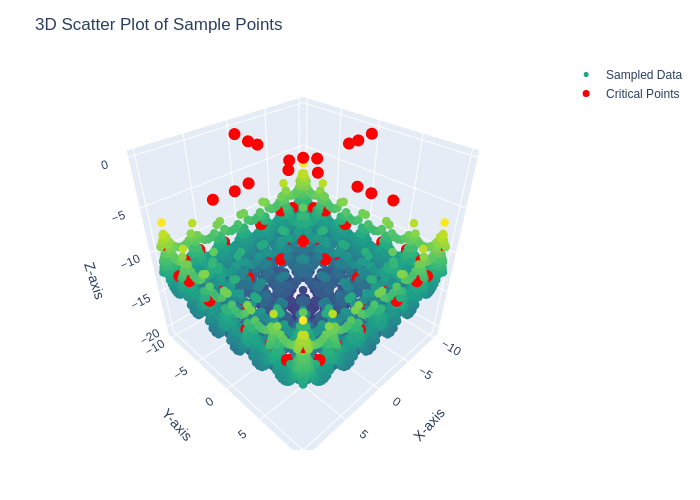

In [21]:
using PlotlyJS, Colors
# Extract coordinates and function values
coords = poly_approx.scale_factor * poly_approx.grid
z_coords = poly_approx.z

# Plot the 3D scatter plot if the dimensions are 2
if size(coords)[2] == 2
    scatter_trace = scatter3d(
        x=coords[:, 1],
        y=coords[:, 2],
        z=z_coords,
        mode="markers",
        marker=attr(
            size=5,
            color=z_coords,
            colorscale="Viridis"
        ),
        name="Sampled Data"
    )
    println("Plotting 3D scatter plot")

    # Create the scatter3d trace
    # Had to switch the coordinates of the critical points to match the surface plot for some reason. 
    crit_pts = scatter3d(
        x=df.y,
        y=df.x,
        z=df.z,
        mode="markers",
        marker=attr(
            size=7,
            color="red"
        ),
        name="Critical Points"
    )

    layout = Layout(
        title="3D Scatter Plot of Sample Points",
        scene=attr(
            xaxis=attr(title="X-axis"),
            yaxis=attr(title="Y-axis"),
            zaxis=attr(title="Z-axis")),
        height=800
    )
    plt = Plot([scatter_trace, crit_pts],layout)
    display(plt)
end


One may thing there is an issue with the cross of critical points lifted to the height $ z=0 $, but as we observe, this is really the `CrossInTray` function which admits these highly non smooth features, which are also hard to detect only by sampling. The nice symmetry of the problem make that our critical points arise where the "singularities" are located.

In [7]:
println(f([0.,0.]))
println(f([0.01, 0.01]))

-0.001
-8.764918257504926


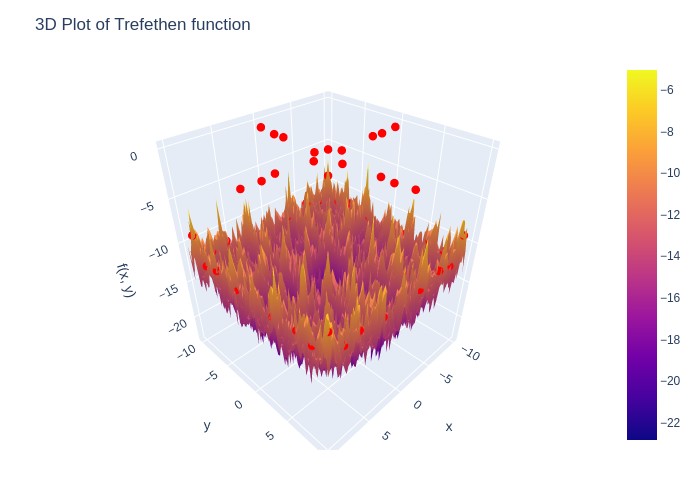

In [19]:
# Generate the grid and evaluate the function
N = 100  # resolution of the grid
x = range(-scale_factor, scale_factor, length=N)
y = range(-scale_factor, scale_factor, length=N)
z = [f([xi, yi]) for yi in y, xi in x]
sf = surface(x=x, y=y, z=z)
# flat_crit_pts = scatter3d(x=df.y, y=df.x, z=df.z, mode="markers", marker_size=5, name="Critical Points")
# Layout for the plot
layout = Layout(title="3D Plot of Trefethen function",
    scene=attr(
        xaxis_title="x",
        yaxis_title="y",
        zaxis_title="f(x, y)"),
        height=800
)
# Display the plot layout,
plt = plot([sf, crit_pts], layout)

In [9]:
# Save the plot as an HTML file to preserve the animation
# savefig(plt, "CrossInTray_function_plot.html")

### Add a Random Noise

We equip the evaluations of `CrossInTray` with a Gaussian noise.

In [10]:
using Distributions
# Define the noisy version of the objective function
function noisy_CrossInTray(xx::Vector{Float64}; mean::Float64=0.0, stddev::Float64=1.0)::Float64
    noise = rand(Normal(mean, stddev))
    return CrossInTray(xx) + noise
end

f = noisy_CrossInTray
d = 4
noisy_tol_l2 = 4e-2             # Define the noise affected tolerance for the L2-norm

while true # Potential infinite loop
    global poly_approx_noisy = MainGenerate(f, 2, d, delta, alpha, scale_factor, 0.5) # computes the approximant in Chebyshev basis
    if poly_approx_noisy.nrm < noisy_tol_l2
        println("attained the desired L2-norm: ", poly_approx_noisy.nrm)
        break
    else
        println("current L2-norm: ", poly_approx_noisy.nrm)
        println("Number of samples: ", poly_approx_noisy.N)
        global d += 1
    end
end

current L2-norm: 0.07628867962020648
Number of samples: 17
current L2-norm: 0.22307284884955972
Number of samples: 22
current L2-norm: 0.14353267868922975
Number of samples: 28
current L2-norm: 0.047419488614057315
Number of samples: 35
current L2-norm: 0.08329470609391941
Number of samples: 42
current L2-norm: 0.0723997040813468
Number of samples: 50
current L2-norm: 0.060611079623056535
Number of samples: 58
attained the desired L2-norm: 0.024750313637650886


In [11]:
ap = main_nd(n, d, poly_approx_noisy.coeffs)
# Expand the polynomial approximant to the standard monomial basis in the Lexicographic order w.r.t x. 
@polyvar(x[1:n]) # Define polynomial ring 
PolynomialApproximant = sum(Float64.(ap) .* MonomialVector(x, 0:d)) # Convert coefficients to Float64 for homotopy continuation
grad = differentiate.(PolynomialApproximant, x)
sys = System(grad)
Real_sol_lstsq = HomotopyContinuation.solve(sys)
real_pts = HomotopyContinuation.real_solutions(Real_sol_lstsq; only_real=true, multiple_results=false)
condition(point) = -1 < point[1] < 1 && -1 < point[2] < 1
filtered_points = filter(condition, real_pts) # Filter points using the filter function
# Colllect the critical points of the approximant 
h_x = Float64[point[1] for point in filtered_points] # Initialize the x vector for critical points of approximant
h_y = Float64[point[2] for point in filtered_points] # Initialize the y vector

# Here we should evaluate on the noiseless function to compare with previous results
h_z = map(p -> CrossInTray([p[1], p[2]]), zip(scale_factor * h_x, scale_factor * h_y))

df_noisy = DataFrame(x=scale_factor * h_x, y=scale_factor * h_y, z=h_z); # Create a DataFrame

Plotting 3D scatter plot


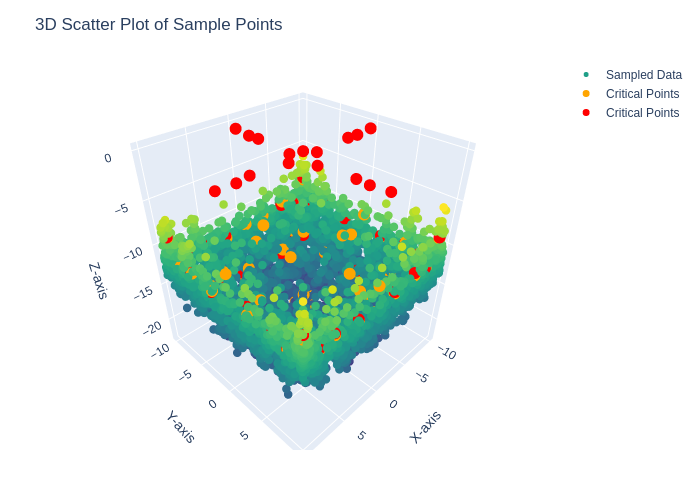

In [22]:
coords = poly_approx_noisy.scale_factor * poly_approx_noisy.grid
z_coords = poly_approx_noisy.z

# Plot the 3D scatter plot if the dimensions are 2
if size(coords)[2] == 2
    scatter_trace = scatter3d(
        x=coords[:, 1],
        y=coords[:, 2],
        z=z_coords,
        mode="markers",
        marker=attr(
            size=5,
            color=z_coords,
            colorscale="Viridis"
        ),
        name="Sampled Data"
    )
    println("Plotting 3D scatter plot")

    # Create the scatter3d trace
    # Had to switch the coordinates of the critical points to match the surface plot for some reason. 
    crit_pts_noisy = scatter3d(
        x=df_noisy.y,
        y=df_noisy.x,
        z=df_noisy.z,
        mode="markers",
        marker=attr(
            size=7,
            color="orange"
        ),
        name="Critical Points"
    )

    layout = Layout(
        title="3D Scatter Plot of Sample Points",
        scene=attr(
            xaxis=attr(title="X-axis"),
            yaxis=attr(title="Y-axis"),
            zaxis=attr(title="Z-axis")),
        height=800
    )
    plt = Plot([scatter_trace, crit_pts_noisy, crit_pts], layout)
end

In [23]:
# savefig(plt, "../data/figures/Noisy_CrossInTray.html")

"../data/figures/Noisy_CrossInTray.html"